### Generate time series from given PSD

Example script to generate a sequence of phase errors (to apply in the simulations) by taking the inverse discrete Fourier transform of the square root of the power spectral density (created by Andy).


2) Compute the PSD of the signal, $\rm PSD(f(k))$

3) Before applying the iDFT:

a) Convert the noise power to FFT amplitue, $A(f(k))= \sqrt{(PSD(f(k))}$

b) Give each spectral component a random phase, uniformly distributed between 0 and the frange, $\rm Phi(f(k))$

c) Construct a frequency domain signal $\rm Z(f(k)) = A(f(k)) \cdot e^{i  Phi(f(k))}$. This is the FFT of the noise spectrum

- Note that this signal contains only the positive-frequency terms,  f(k) > 0 (one-sided).
- However, the fft as returned from the numpy functions include also the negative-frequency terms. Specifically it is ordered as follows:
        - a[0] contains the zero frequency terms

        - a[1:n//2] contains the positive-frequency terms,

        - a[n//2 + 1:] contains the negative-frequency terms, in increasing order starting from the most negative frequency.
- In order to bring the signal $\rm Z(f(k))$ at this form, we:

    a)  Create a list with the complex conjugates of all but the first elements of the frequency signal, the first element is set later to zero
    
    b)  We reverse the order of the list and merge it with the initial signal
    
    c)  Set the first element to zero
    
 4) Apply the iDFT. 
 
 
 The output of the iDFT will be a random time series on the finite (bounded, limited) time interval t = 0 to tmax = (N-1) X Dt, where Dt = 1 / (frange).

 The noise signal (time series), variable $y2$, is the real part of the result. 

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. Load the measured PSD

In [65]:
df = pd.read_csv("coast3EX-10DBm.csv")

In [66]:
df

,Offset Frequency (Hz),Phase Noise (dBc/Hz)
0,1000.000000,-103.746045
1,1018.009751,-103.823889
2,1036.343854,-104.874646
3,1055.008148,-104.950599
4,1074.008583,-105.575700
...,...,...
383,931091.255809,-144.238890
384,947859.977652,-143.591741
385,964930.700003,-143.434868
386,982308.861817,-143.406605


### 2) Convert the power spectral density in rad^2/Hz

\begin{equation}
S(f) = 2 \cdot 10^{L(f)/10}
\end{equation}

where $\rm S(f)$ the power spectral density in $ \rm rad^2/Hz$ and $\rm L(f)$ the measurement in $ \rm dBc/Hz$.
More in the presentation of 8July2020.

In [5]:
psd = 2*10**(np.array(df['Phase Noise (dBc/Hz)'])/10) # rad^2/Hz, type: numpy.array
freq = np.array(df['Offset Frequency (Hz)'])

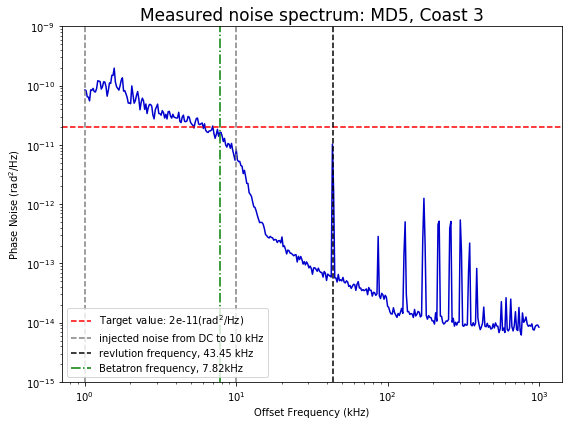

In [7]:
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(freq/1e3, psd, c='mediumblue')
ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.set_ylim(10**(-15), 10**(-9))
ax1.set_xlabel('Offset Frequency (kHz)')
ax1.set_ylabel('Phase Noise '+ r'$\rm (rad^2/Hz)$')
ax1.axhline(2*10**(-110/10), c='r', linestyle='dashed', label='Target value: {}'.format(2*10**(-110/10))+r'$(\rm rad^2/Hz)$')

ax1.axvline(1, c='grey', linestyle='dashed')
ax1.axvline(10, c='grey', linestyle='dashed', label='injected noise from DC to 10 kHz')

ax1.axvline(43.45, c='k', linestyle='dashed', label='revlution frequency, 43.45 kHz')


ax1.axvline(0.18*43.45, c='g', linestyle='dashdot', label='Betatron frequency, {:.3}kHz'.format(0.18*43.45))


ax1.legend(loc=3)
ax1.set_title('Measured noise spectrum: MD5, Coast 3', fontsize=17)

plt.tight_layout()

### 3. Linear interpolation

The measured data are equally spaced in logarithmic scale. We need to do a linear interpolation on the poewer spectral density to the wanted frequency array. 

- Sampling: dt = 1 (sequence of noise kicks applied every turn) --> you want it in time 1/frev = 23 μs.
- Sampling frequency: 1/dt
- Length of signal: N, equals the turns of the simulations

In [75]:
df = 43.45e3 # the sampling frequency is the revolution frequency
dt = 1/df
N = 1e5

freq_3 = np.arange(0, N)*df

xx = np.interp(freq_3, freq, psd) # linear interpolation of the psd

In [70]:
freq_3[1]-freq_3[0]

43450.0

In [73]:
freq_3[-1]/df

99999.0

In [74]:
len(xx)

100000

In [56]:
errors_1 = np.ones(len(freq_3))
psd

[1 2 3 4] [2 1 2 2]
[2 2 6 8]


### 4. Go back to the time series

In [35]:
# Convert the noise power to fft amplitude, A(f(k))
A = np.sqrt(xx*df*(N**2))
A[0] = 0 # set the 0 component to 0

In [41]:
# Give each spectral component a random phase, uniformly distributed between 0 and
# the maximum frequency,  Phi(f(k))
phi = np.exp(1j*2*np.pi*np.random.uniform(0,1,len(freq_3)))

In [42]:
# Construct a frequency domain signal Z(f(k)) = A(f(k)) X e^(i X PHI(f(k))), this is the FFT of the noise spectrum
fft_y2 = A*phi

In [26]:
# complex conjugate of all but the first element
y2fft_conj = np.conj(fft_y2[1:])
# Reverse the list
reversed_list = y2fft_conj[::-1]
# merge them
merged_list = list(fft_y2) + list(reversed_list)
merged_list[0] = 0

In [44]:
y2 = np.real(np.fft.ifft(merged_list))

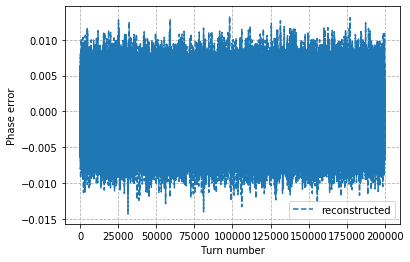

In [48]:
plt.plot(y2, label='reconstructed', linestyle='dashed')
plt.legend()
plt.xlabel('Turn number')
plt.ylabel('Phase error')
plt.grid(True, linestyle='--')

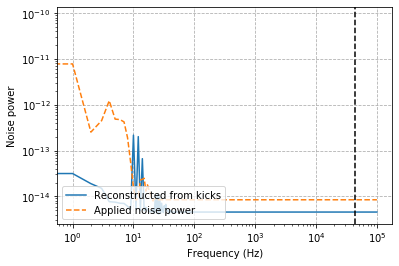

In [49]:
#Reconstruct the noise power spectrum from the phase errors
phaseerrorsfft1 = np.fft.fft(y2)
plt.plot(np.abs(phaseerrorsfft1[1:len(freq_3)])**2/(df*N**2), label='Reconstructed from kicks')
plt.plot(xx, label='Applied noise power', linestyle='--')
plt.legend(loc=3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Noise power')
plt.grid(True, linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.axvline(43.45e3, c='k', linestyle='dashed', label='revlution frequency, 43.45 kHz')